In [700]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sys import getsizeof
from numba import njit

In [701]:
# from https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths

In [702]:
feature_id = 1
DELTA_MZ = 1.003355  # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [731]:
DA_MIN = 100
DA_MAX = 4000
charge = 2

In [732]:
feature_raw_ms2_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/feature-{}-ms2-raw-points.pkl'.format(feature_id))
feature_raw_ms2_df.sort_values(by=['mz'], ascending=True, inplace=True)
feature_raw_ms2_df['decharged_mass'] = (feature_raw_ms2_df.mz + PROTON_MASS) * charge
feature_raw_ms2_df['normalised_intensity'] = feature_raw_ms2_df.intensity / feature_raw_ms2_df.intensity.max()

In [733]:
feature_raw_ms2_df.head()

,frame_id,mz,intensity,decharged_mass,normalised_intensity
0,27938,133.596214,9,269.207028,0.068182
1,27938,180.467447,9,362.949493,0.068182
2,27938,213.418260,9,428.851120,0.068182
3,27938,266.156364,9,534.327328,0.068182
4,27938,268.404245,9,538.823090,0.068182


In [734]:
len(feature_raw_ms2_df)

215

In [735]:
# generate a charge-aware mask of mass defect windows
bin_edges_l = []
for nominal_mass in np.arange(start=DA_MIN, stop=DA_MAX, step=1/charge):
    proton_mass_adjustment = (charge - 1) * PROTON_MASS
    mass_centre = (nominal_mass + proton_mass_adjustment) * 1.00048  # from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3184890/
    width = (0.19 + (0.0001 * nominal_mass)) / charge
    lower_mass = mass_centre - (width / 2)
    upper_mass = mass_centre + (width / 2)
    bin_edges_l.append(lower_mass)
    bin_edges_l.append(upper_mass)
bins = np.asarray(bin_edges_l)

In [736]:
bins[:20]

array([101.0057835, 101.1057835, 101.506011 , 101.606036 , 102.0062385,
       102.1062885, 102.506466 , 102.606541 , 103.0066935, 103.1067935,
       103.506921 , 103.607046 , 104.0071485, 104.1072985, 104.507376 ,
       104.607551 , 105.0076035, 105.1078035, 105.507831 , 105.608056 ])

In [737]:
np.digitize(99.95, bins)

0

In [738]:
decharged_mass_a = feature_raw_ms2_df.decharged_mass.to_numpy()
mz_a = feature_raw_ms2_df.mz.to_numpy()
intensity_a = feature_raw_ms2_df.intensity.to_numpy()
available_a = np.full((len(mz_a)), True)  # the raw points not yet assigned to a peak

In [739]:
digitised_mass = np.digitize(decharged_mass_a[available_a == True], bins)  # an odd index means the point is inside a mass defect window
digitised_mass

array([  674,  1048,  1312,  1734,  1751,  1928,  1933,  1958,  2029,
        2156,  2206,  2229,  2438,  2483,  2493,  2493,  2606,  2781,
        2805,  2821,  2829,  2869,  2900,  2902,  2910,  2925,  2941,
        2998,  3037,  3053,  3053,  3068,  3101,  3229,  3269,  3328,
        3341,  3421,  3485,  3520,  3597,  3597,  3637,  3661,  3693,
        3693,  3701,  3702,  3772,  3781,  3837,  3838,  3845,  3845,
        3853,  3861,  3861,  3925,  3925,  3925,  3933,  3933,  3941,
        3941,  3941,  3957,  4005,  4012,  4037,  4063,  4197,  4213,
        4232,  4253,  4308,  4341,  4398,  4470,  4478,  4525,  4526,
        4540,  4597,  4605,  4737,  4741,  4744,  4749,  4813,  4925,
        4958,  4965,  4981,  4989,  5168,  5201,  5205,  5269,  5318,
        5425,  5601,  5601,  5662,  5756,  5805,  5877,  5884,  5885,
        5892,  5892,  5893,  5958,  6093,  6206,  6436,  6436,  6437,
        6444,  6444,  6445,  6445,  6445,  6445,  6452,  6452,  6453,
        6453,  6453,

In [740]:
# consecutive odd indexes means consecutive windows, suggesting a series of isotopic peaks

In [741]:
# remove all the even indexes - the odd indexes are the mass defect windows
mass_defect_window_indexes = digitised_mass[(digitised_mass % 2) == 1]
mass_defect_window_indexes

array([ 1751,  1933,  2029,  2229,  2483,  2493,  2493,  2781,  2805,
        2821,  2829,  2869,  2925,  2941,  3037,  3053,  3053,  3101,
        3229,  3269,  3341,  3421,  3485,  3597,  3597,  3637,  3661,
        3693,  3693,  3701,  3781,  3837,  3845,  3845,  3853,  3861,
        3861,  3925,  3925,  3925,  3933,  3933,  3941,  3941,  3941,
        3957,  4005,  4037,  4063,  4197,  4213,  4253,  4341,  4525,
        4597,  4605,  4737,  4741,  4749,  4813,  4925,  4965,  4981,
        4989,  5201,  5205,  5269,  5425,  5601,  5601,  5805,  5877,
        5885,  5893,  6093,  6437,  6445,  6445,  6445,  6445,  6453,
        6453,  6453,  6453,  6453,  6453,  6453,  6453,  6453,  6453,
        6461,  6461,  6461,  6461,  6461,  6461,  6461,  6461,  6461,
        6717,  6973,  7189,  7221,  7349,  7349,  7349,  7357,  7357,
        7365,  7373,  7373,  7989,  8045,  8149,  8149,  8157,  8157,
        8157,  8157,  8157,  8165,  8165,  8165,  8165,  8165,  8173,
        8173,  8189,

In [742]:
# remove the duplicates
unique_mass_defect_window_indexes = np.unique(mass_defect_window_indexes)
unique_mass_defect_window_indexes

array([ 1751,  1933,  2029,  2229,  2483,  2493,  2781,  2805,  2821,
        2829,  2869,  2925,  2941,  3037,  3053,  3101,  3229,  3269,
        3341,  3421,  3485,  3597,  3637,  3661,  3693,  3701,  3781,
        3837,  3845,  3853,  3861,  3925,  3933,  3941,  3957,  4005,
        4037,  4063,  4197,  4213,  4253,  4341,  4525,  4597,  4605,
        4737,  4741,  4749,  4813,  4925,  4965,  4981,  4989,  5201,
        5205,  5269,  5425,  5601,  5805,  5877,  5885,  5893,  6093,
        6437,  6445,  6453,  6461,  6717,  6973,  7189,  7221,  7349,
        7357,  7365,  7373,  7989,  8045,  8149,  8157,  8165,  8173,
        8189,  8445,  8685,  8885,  9045,  9053,  9061,  9189,  9197,
        9205,  9213,  9259,  9461,  9477,  9569,  9669, 10305, 10477,
       12261])

In [743]:
len(unique_mass_defect_window_indexes)

100

In [744]:
# the elements of unique_mass_defect_window_indexes are the bin indexes (mass defect windows) that have signal present

In [745]:
# find where the windows are consecutive
condition = (np.diff(unique_mass_defect_window_indexes) == 2)
condition = np.hstack((condition[0],condition))  # now the flags correspond to whether each mass window is adjacent to the next one
condition

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [746]:
len(condition)

100

In [747]:
# the False values are stand-alone peaks we need to process as orphaned isotopes

In [748]:
run_values, run_starts, run_lengths = find_runs(condition)

In [749]:
run_values

array([False])

In [750]:
chunk_sizes = run_lengths[run_values == True]
chunk_sizes

array([], dtype=int64)

In [751]:
chunk_starts = run_starts[run_values == True]
chunk_starts

array([], dtype=int64)

In [752]:
peaks_l = []
isotope_series_indexes = []
expected_peak_spacing = DELTA_MZ / charge
for series_idx in range(len(chunk_sizes)):
    number_of_windows = chunk_sizes[series_idx]
    start_idx = chunk_starts[series_idx]
    index_list = unique_mass_defect_window_indexes[start_idx:start_idx+number_of_windows].tolist()
    print("isotope series {} ({} peaks):".format(series_idx+1, number_of_windows))
    mz_l = []
    int_l = []
    for peak_idx,i in enumerate(index_list):
        isotope_series_indexes.append(i)
        lower_mass = round(bins[i-1],4)
        upper_mass = round(bins[i],4)
        print("mass defect window [{}]: {}-{} Da".format(i, lower_mass, upper_mass))
        # get the raw points allocated to this bin
        peak_indexes = np.where(digitised_mass == i)[0]
        print("\tpeak mass {}".format(np.round(decharged_mass_a[peak_indexes],4)))
        print("\tpeak m/z {}".format(np.round(mz_a[peak_indexes],4)))
        mz_centroid = np.average(mz_a[peak_indexes], weights=intensity_a[peak_indexes])
        intensity = np.sum(intensity_a[peak_indexes])
        mz_l.append(mz_centroid)
        int_l.append(intensity)
        print("\tpeak centroid {} m/z, {}".format(np.round(mz_centroid,4), intensity))
        available_a[peak_indexes] = False
    # de-isotope the peaks
    peaks_mz_a = np.array(mz_l)
    peaks_int_a = np.array(int_l)
    for i in range(len(peaks_mz_a)):
        peaks_mz_a[i] = peaks_mz_a[i] - (i * expected_peak_spacing)
    print("de-isotoped m/z {}".format(np.round(peaks_mz_a,4)))
    deisotoped_mz = np.average(peaks_mz_a, weights=peaks_int_a)
    deisotoped_intensity = peaks_int_a.sum()
    print("de-isotoped m/z centroid {}, {}".format(np.round(deisotoped_mz,4), deisotoped_intensity))
    monoisotopic_mass = (deisotoped_mz - PROTON_MASS) * charge
    print("monoisotopic mass {} Da".format(np.round(monoisotopic_mass,4)))
    peaks_l.append((series_idx, monoisotopic_mass, deisotoped_intensity))
    print()
    

In [753]:
# process the peaks that remain - the orphans
orphaned_chunk_sizes = run_lengths[run_values == False]
orphaned_chunk_sizes

array([100])

In [754]:
number_of_orphans = orphaned_chunk_sizes.sum()
number_of_orphans

100

In [755]:
orphaned_chunk_starts = run_starts[run_values == False]
orphaned_chunk_starts

array([0])

In [756]:
peak_idx = 1
orphan_indexes = []
for i in range(len(orphaned_chunk_sizes)):
    chunk_size = orphaned_chunk_sizes[i]
    chunk_start = orphaned_chunk_starts[i]
    for chunk_idx in range(chunk_size):
        index = unique_mass_defect_window_indexes[chunk_start+chunk_idx]
        lower_mass = round(bins[index-1],4)
        upper_mass = round(bins[index],4)
        print("mass defect window [{}]: {}-{} Da".format(index, lower_mass, upper_mass))
        orphan_indexes.append(index)
        # get the raw points allocated to this bin
        peak_indexes = np.where(digitised_mass == index)[0]
        print("\tpeak mass {}".format(np.round(decharged_mass_a[peak_indexes],4)))
        print("\tpeak m/z {}".format(np.round(mz_a[peak_indexes],4)))
        mz_centroid = np.average(mz_a[peak_indexes], weights=intensity_a[peak_indexes])
        intensity = np.sum(intensity_a[peak_indexes])
        print("\tpeak centroid {} m/z, {}".format(np.round(mz_centroid,4), intensity))
        monoisotopic_mass = (mz_centroid - PROTON_MASS) * charge
        peaks_l.append((0, monoisotopic_mass, intensity))
        peak_idx += 1
        

mass defect window [1751]: 538.7048-538.8267 Da
	peak mass [538.8231]
	peak m/z [268.4042]
	peak centroid 268.4042 m/z, 9
mass defect window [1933]: 584.2255-584.3497 Da
	peak mass [584.3092]
	peak m/z [291.1473]
	peak centroid 291.1473 m/z, 44
mass defect window [2029]: 608.2365-608.3618 Da
	peak mass [608.2756]
	peak m/z [303.1305]
	peak centroid 303.1305 m/z, 83
mass defect window [2229]: 658.2592-658.3871 Da
	peak mass [658.2922]
	peak m/z [328.1388]
	peak centroid 328.1388 m/z, 132
mass defect window [2483]: 721.7881-721.9191 Da
	peak mass [721.8509]
	peak m/z [359.9182]
	peak centroid 359.9182 m/z, 9
mass defect window [2493]: 724.2892-724.4204 Da
	peak mass [724.306 724.312]
	peak m/z [361.1457 361.1487]
	peak centroid 361.1474 m/z, 101
mass defect window [2781]: 796.322-796.4568 Da
	peak mass [796.3397]
	peak m/z [397.1626]
	peak centroid 397.1626 m/z, 54
mass defect window [2805]: 802.3247-802.4598 Da
	peak mass [802.454]
	peak m/z [400.2197]
	peak centroid 400.2197 m/z, 58
ma

In [757]:
# check for intersection between sets of mass defect windows
list(set(isotope_series_indexes) & set(orphan_indexes))

[]

In [730]:
peaks_df = pd.DataFrame(peaks_l, columns=['series','monoisotopic_mass','intensity'])
peaks_df['normalised_intensity'] = peaks_df.intensity / peaks_df.intensity.max()

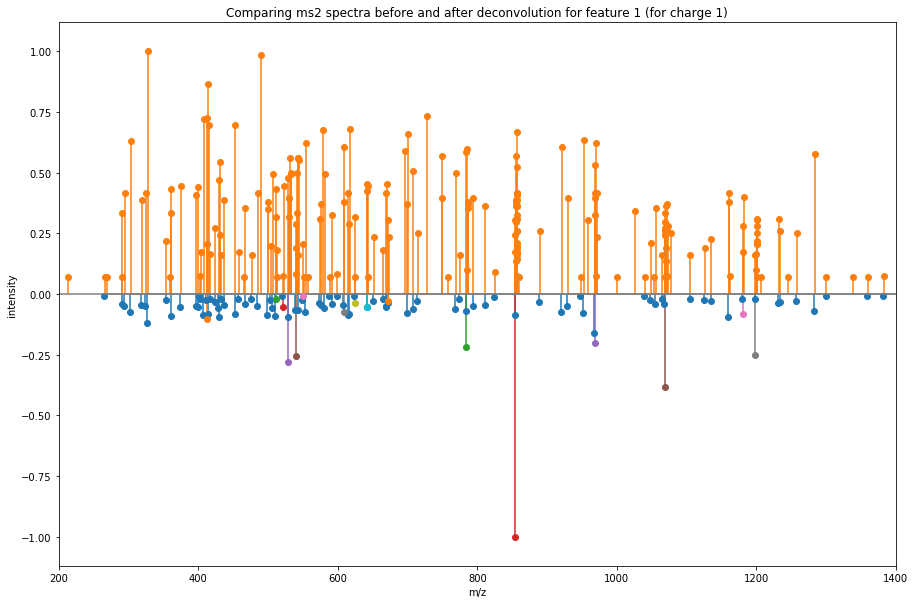

In [699]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

markerline, stemlines, baseline = ax.stem(feature_raw_ms2_df.mz, feature_raw_ms2_df.normalised_intensity, label='before deconvolution', use_line_collection=True)
plt.setp(markerline, 'color', colors[1])
plt.setp(stemlines, 'color', colors[1])
plt.setp(baseline, 'color', colors[7])

groups = peaks_df.groupby('series')
for i, (name, group) in enumerate(groups):
    markerline, stemlines, baseline = ax.stem(group.monoisotopic_mass, -group.normalised_intensity, label=name, use_line_collection=True)
    plt.setp(markerline, 'color', colors[i % len(colors)])
    plt.setp(stemlines, 'color', colors[i % len(colors)])
    plt.setp(baseline, 'color', colors[7])

plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(10)
f.set_figwidth(15)
ax.set_xlim((200,1400))
plt.margins(0.06)
# plt.legend(loc='best')
plt.title('Comparing ms2 spectra before and after deconvolution for feature {} (for charge {})'.format(feature_id, charge))
plt.show()